In [1]:
import pandas as pd
import numpy as np
import os
from scipy.cluster.vq import whiten
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.vq import kmeans, vq
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import nltk
from collections import Counter
import string
import seaborn as sns
%matplotlib inline
import datetime
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [34]:
sheet_to_df_map = pd.read_excel('online_retail_II.xlsx', sheet_name=None)
online_retailer = pd.concat(sheet_to_df_map, axis=0, ignore_index=True)

In [35]:
online_retailer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [36]:
online_retailer.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [37]:
online_retailer.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [38]:
#Understanding and cleaning data
#1. rows with less than 0 quantity, are cancelled orders
online_retailer[online_retailer['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [39]:
# rows with negative price are bad debt adjustments
online_retailer[online_retailer['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [47]:
#2. remove rows without Customer ID
online_retailer_1=online_retailer.dropna(subset=['Customer ID'])
online_retailer_1=online_retailer_1.drop(columns=['Invoice','Description','StockCode'])

In [48]:
online_retailer_1.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [49]:
#online_retailer_1['Amount']=online_retailer_1.Price* online_retailer_1.Quantity
online_retailer_1.loc[:,'Amount'] = online_retailer_1.Price* online_retailer_1.Quantity

In [50]:
online_retailer_1.head()

,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [51]:
#Invoice Date and Customer ID format change
online_retailer_1.InvoiceDate = pd.to_datetime(online_retailer_1.InvoiceDate)
online_retailer_1['Customer ID']=online_retailer_1['Customer ID'].apply(str)

In [52]:
online_retailer_1.head()

,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [53]:
online_retailer_2=online_retailer_1.copy()

In [54]:
reference_date = online_retailer_2.InvoiceDate.max() + datetime.timedelta(days = 1)
online_retailer_2['days_from_last_purchase'] = (reference_date - 
online_retailer_2.InvoiceDate).astype('timedelta64[D]')
lastpurchase_day = online_retailer_2[['Customer ID','days_from_last_purchase']].groupby('Customer ID').min().reset_index()
lastpurchase_day.rename(columns={'days_from_last_purchase':'recency'}, inplace=True)

In [56]:
lastpurchase_day.head()

,Customer ID,recency
0,12346.0,326.0
1,12347.0,2.0
2,12348.0,75.0
3,12349.0,19.0
4,12350.0,310.0


C:\Users\rayanoothalav\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


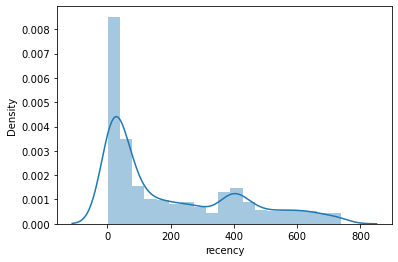

In [94]:
#Recency distribution plot
x=lastpurchase_day['recency']
ax=sns.distplot(x)

In [57]:
# Amount spent by each customer
customer_spending=pd.DataFrame(online_retailer_2.groupby('Customer ID')['Amount'].sum())
customer_spending=customer_spending.rename(columns={'Amount': 'Spending'})
customer_spending=customer_spending.reset_index()
customer_spending.head()

,Customer ID,Spending
0,12346.0,-64.68
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4404.54
4,12350.0,334.40


In [58]:
customer_spending.describe()

,Spending
count,5942.000000
mean,2801.799459
std,13973.922553
min,-25111.090000
25%,325.097500
50%,843.970000
75%,2182.005000
max,598215.220000


C:\Users\rayanoothalav\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


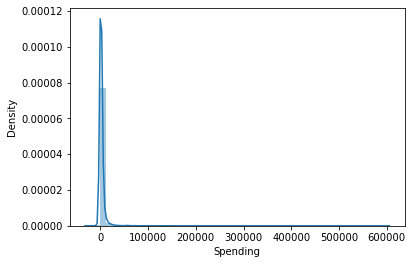

In [93]:
#Monetery distribution plot
x=customer_spending['Spending']
ax=sns.distplot(x)

In [59]:
customer_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5942 non-null   object 
 1   Spending     5942 non-null   float64
dtypes: float64(1), object(1)
memory usage: 93.0+ KB


In [60]:
#5942 customers have spent on average apprx. 2801.80

In [61]:
No_of_times=pd.DataFrame(online_retailer_2.groupby('Customer ID')['InvoiceDate'].nunique())
No_of_times = No_of_times.rename(columns={'InvoiceDate': 'Purchase_Frequency'})
No_of_times = No_of_times.reset_index()
No_of_times.head()

,Customer ID,Purchase_Frequency
0,12346.0,17
1,12347.0,8
2,12348.0,5
3,12349.0,5
4,12350.0,1


In [63]:
No_of_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         5942 non-null   object
 1   Purchase_Frequency  5942 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 93.0+ KB


In [64]:
No_of_times.describe()

,Purchase_Frequency
count,5942.000000
mean,7.511612
std,15.836676
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,508.000000


C:\Users\rayanoothalav\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


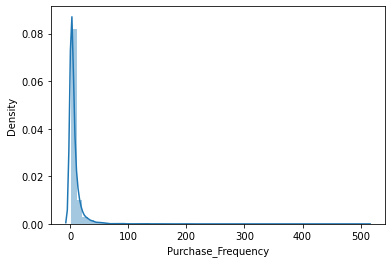

In [95]:
#Frequency of purchase distribution plot
x=No_of_times['Purchase_Frequency']
ax=sns.distplot(x)

In [65]:
#Each customers has purchased on average apprx. 7.5 times in 2 years, minimum 1 and maximum 508 times

In [67]:
segment_2=[lastpurchase_day,customer_spending, No_of_times]
import functools as ft
segment_2_final = ft.reduce(lambda left, right: pd.merge(left, right, on='Customer ID'), segment_2)

In [69]:
segment_2_final.head()

,Customer ID,recency,Spending,Purchase_Frequency
0,12346.0,326.0,-64.68,17
1,12347.0,2.0,5633.32,8
2,12348.0,75.0,2019.40,5
3,12349.0,19.0,4404.54,5
4,12350.0,310.0,334.40,1


In [123]:
segment_2_final.describe()

,recency,Spending,Purchase_Frequency
count,5942.000000,5942.000000,5942.000000
mean,202.908617,2801.799459,7.511612
std,211.857936,13973.922553,15.836676
min,1.000000,-25111.090000,1.000000
25%,25.000000,325.097500,2.000000
50%,96.000000,843.970000,4.000000
75%,381.000000,2182.005000,8.000000
max,739.000000,598215.220000,508.000000


In [228]:
###Calculating quantile values
quintiles = segment_2_final[['recency', 'Spending', 'Purchase_Frequency']].quantile([.2, .25, .3, .35, .4, .5, .6, .7, .8, .9]).to_dict()
###Benchmark to give score for recency indicator
def r_score(r):
    if r < quintiles['recency'][.2]:
        return 3 
    elif r < quintiles['recency'][.8]:
        return 2
    else: 
        return 1
###Benchmark to give score for frequency & monetary indicator.   
def fm_score(f): 
    if f > quintiles['Purchase_Frequency'][.8]:
        return 3
    elif f > quintiles['Purchase_Frequency'][.2]: 
        return 2
    else: 
        return 1 

In [229]:
rfm2 = segment_2_final.copy()
rfm2['r_score'] = rfm2.recency.apply(lambda x: r_score(x))
rfm2['f_score'] = rfm2.Purchase_Frequency.apply(lambda x: fm_score(x))
rfm2['m_score'] = rfm2.Spending.apply(lambda x: fm_score(x))
rfm2['rfm'] = rfm2['r_score'].map(str)+rfm2['f_score'].map(str) + rfm2['m_score'].map(str)
rfm2['rfm_scores']=rfm2[['r_score','f_score','m_score']].sum(axis=1)

In [230]:
rfm2.head()

,Customer ID,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm,rfm_scores
0,12346.0,326.0,-64.68,17,2,3,1,231,6
1,12347.0,2.0,5633.32,8,3,2,3,323,8
2,12348.0,75.0,2019.40,5,2,2,3,223,7
3,12349.0,19.0,4404.54,5,2,2,3,223,7
4,12350.0,310.0,334.40,1,2,1,3,213,6


In [231]:
rfm2.describe()

,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm_scores
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000
mean,202.908617,2801.799459,7.511612,1.989398,1.940256,2.963480,6.893134
std,211.857936,13973.922553,15.836676,0.625488,0.654351,0.265593,1.166146
min,1.000000,-25111.090000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,25.000000,325.097500,2.000000,2.000000,2.000000,3.000000,6.000000
50%,96.000000,843.970000,4.000000,2.000000,2.000000,3.000000,7.000000
75%,381.000000,2182.005000,8.000000,2.000000,2.000000,3.000000,8.000000
max,739.000000,598215.220000,508.000000,3.000000,3.000000,3.000000,9.000000


In [227]:
#RFM Clustering
###Loyal Customers, who are the champions of all the customers with highest score of RFM. 
rfm2_group1 = rfm2[rfm2['rfm']=='333']
rfm2_group1.loc[:,'Segment_name'] = 'champion'
rfm2_group1.loc[:,'cluster'] = 1
###Customers who have the most potential to become the Champions. They recently buy the products and they make their purchases quite frequently. Moreover, the amount they spent is quite great. 
rfm2_group2 = rfm2[rfm2['rfm'].str.contains('332|331|323|313')] 
rfm2_group2.loc[:,'Segment_name'] = 'potential1'
rfm2_group2.loc[:,'cluster'] = 2
###Customers whose frequency score and monetary score are slightly lower than potential 1 group
rfm2_group3 = rfm2[rfm2['rfm'].str.contains('321|322|311|312')] 
rfm2_group3.loc[:,'Segment_name'] = 'potential2'
rfm2_group3.loc[:,'cluster'] = 3
###Customers who used to pay a lot of money and come to the store frequently. They did not purchase recently. 
rfm2_group4 = rfm2[rfm2['rfm'].str.contains('233')]
rfm2_group4.loc[:,'Segment_name'] = 'needing_attention1'
rfm2_group4.loc[:,'cluster'] = 4
###Customers who do not come to store often and not frequently make purchases.
rfm2_group5 = rfm2[rfm2['rfm'].str.contains('223|213|212|231|232|211|221|222')]
rfm2_group5.loc[:,'Segment_name'] = 'needing_attention2'
rfm2_group5.loc[:,'cluster'] = 5
###Customers who haven't paid a visit to the store for a long time. However, once in a while, they do spend lot of money
rfm2_group6 = rfm2[rfm2['rfm'].str.contains('132|123|113|133')]
rfm2_group6.loc[:,'Segment_name'] = 'lost1'
rfm2_group6.loc[:,'cluster'] = 6
###Customers who churn
rfm2_group7 = rfm2[rfm2['rfm'].str.contains('111|112|121|122|131')]
rfm2_group7.loc[:,'Segment_name'] = 'lost2'
rfm2_group7.loc[:,'cluster'] = 7

C:\Users\rayanoothalav\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\rayanoothalav\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [136]:
import pandas as pd
rfm2_together=pd.concat([rfm2_group1,rfm2_group2,rfm2_group3,rfm2_group4,rfm2_group5,rfm2_group6,rfm2_group7],axis=0)
rfm2_together.head()

,Customer ID,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm,rfm_scores,Segment_name,cluster
13,12359.0,8.0,8714.89,14,3,3,3,333,9,champion,1
16,12362.0,3.0,5284.58,14,3,3,3,333,9,champion,1
49,12395.0,16.0,5046.92,18,3,3,3,333,9,champion,1
71,12417.0,3.0,6708.21,27,3,3,3,333,9,champion,1
77,12423.0,1.0,2612.19,11,3,3,3,333,9,champion,1


In [137]:
rfm2_together.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5942 entries, 13 to 5769
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         5942 non-null   object 
 1   recency             5942 non-null   float64
 2   Spending            5942 non-null   float64
 3   Purchase_Frequency  5942 non-null   int64  
 4   r_score             5942 non-null   int64  
 5   f_score             5942 non-null   int64  
 6   m_score             5942 non-null   int64  
 7   rfm                 5942 non-null   object 
 8   rfm_scores          5942 non-null   int64  
 9   Segment_name        5942 non-null   object 
 10  cluster             5942 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 557.1+ KB


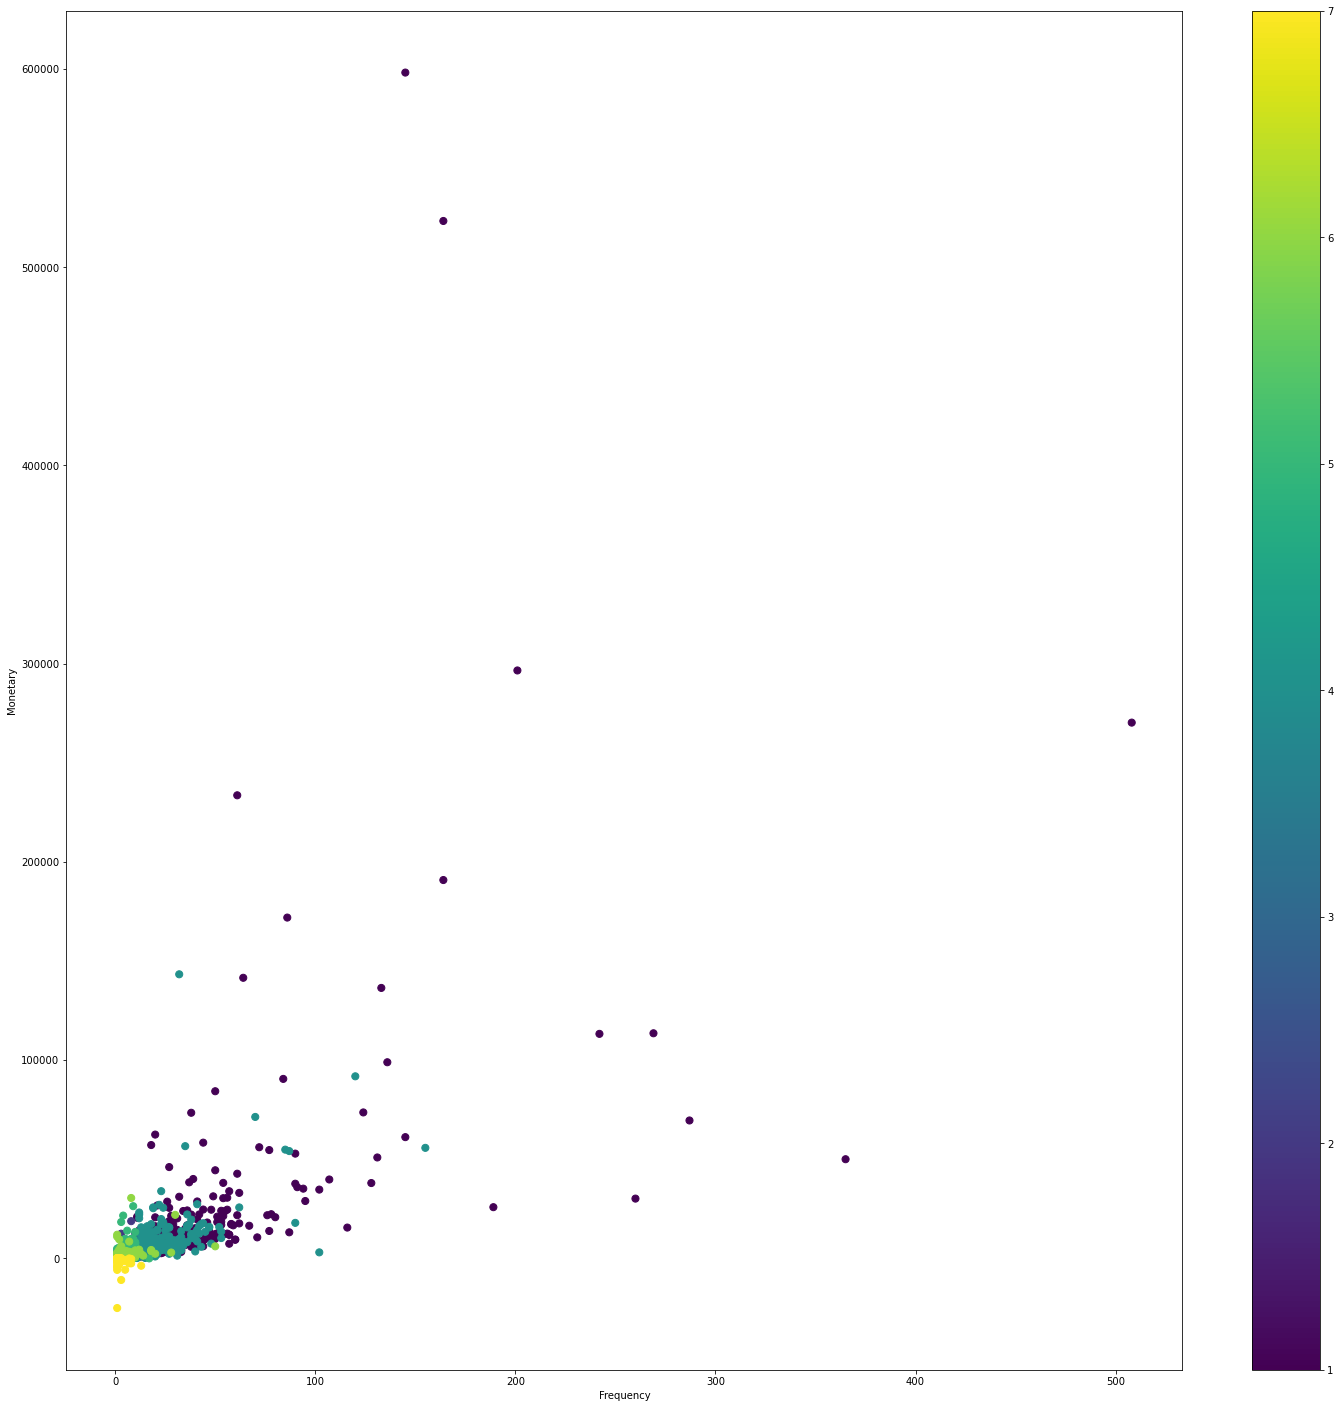

In [156]:
import matplotlib.pyplot as plt

# Scatter plot of Purchase_Frequency vs. Monetary
x = rfm2_together['Purchase_Frequency']
y = rfm2_together['Spending']
Cluster = rfm2_together['cluster']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)

ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
plt.colorbar(scatter)

plt.show()

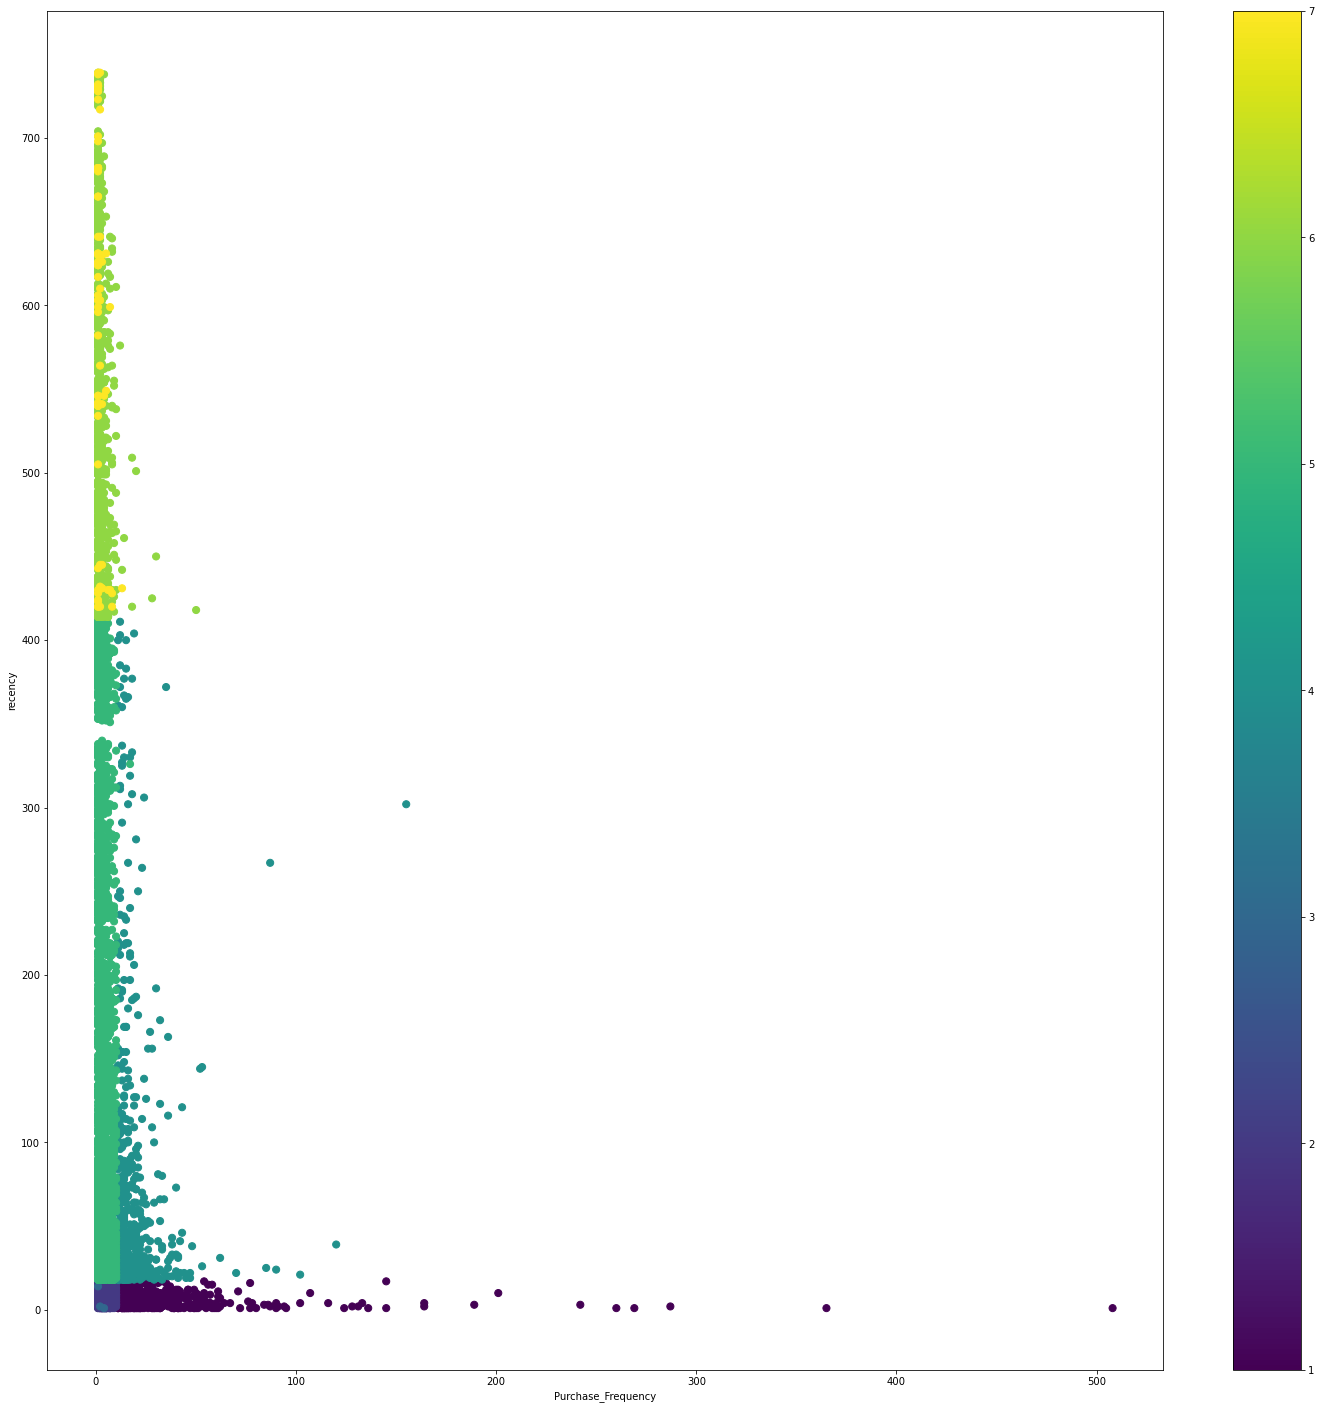

In [157]:
# Scatter plot of Recency vs. Frequency
x = rfm2_together['Purchase_Frequency']
y = rfm2_together['recency']
Cluster = rfm2_together['cluster']
#centers = rfm2_together.random(7, 2) 

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)
#for i,j in centers:
#    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('Purchase_Frequency')
ax.set_ylabel('recency')
plt.colorbar(scatter)

plt.show()

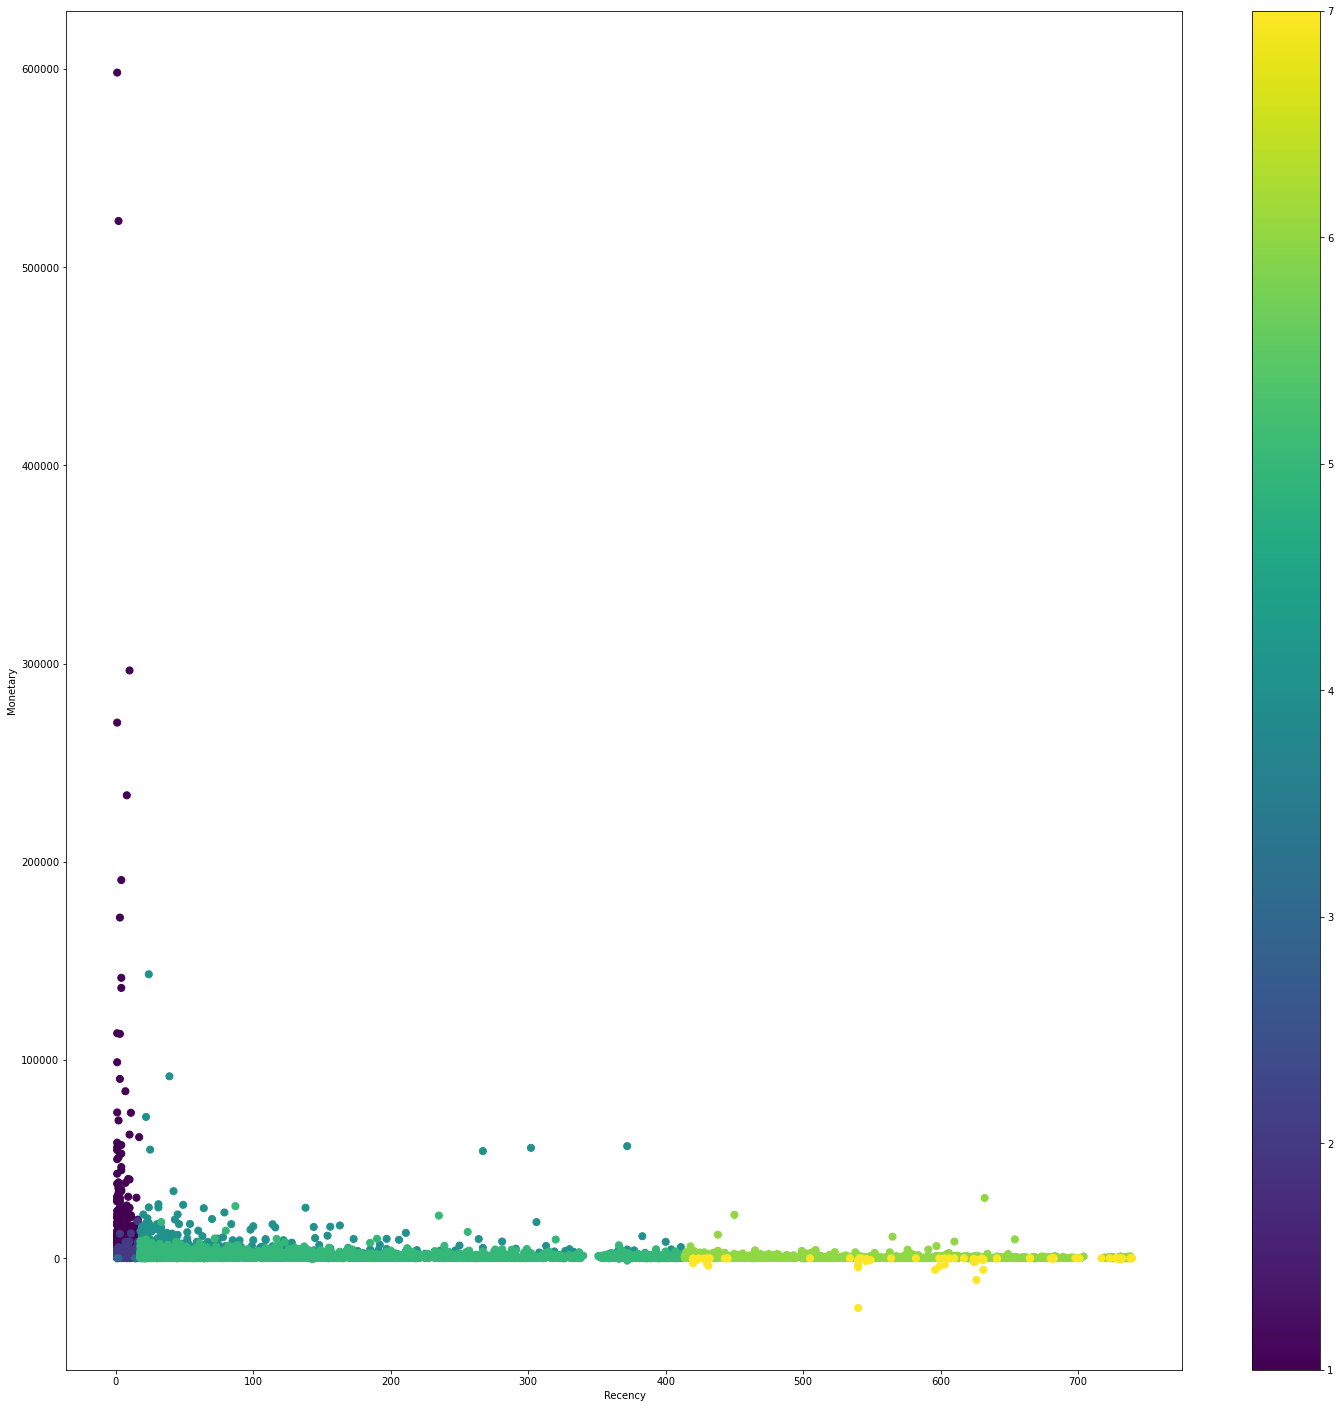

In [158]:
# Scatter plot of Recency vs. Monetary
x = rfm2_together['recency']
y = rfm2_together['Spending']
Cluster = rfm2_together['cluster']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
plt.colorbar(scatter)

plt.show()

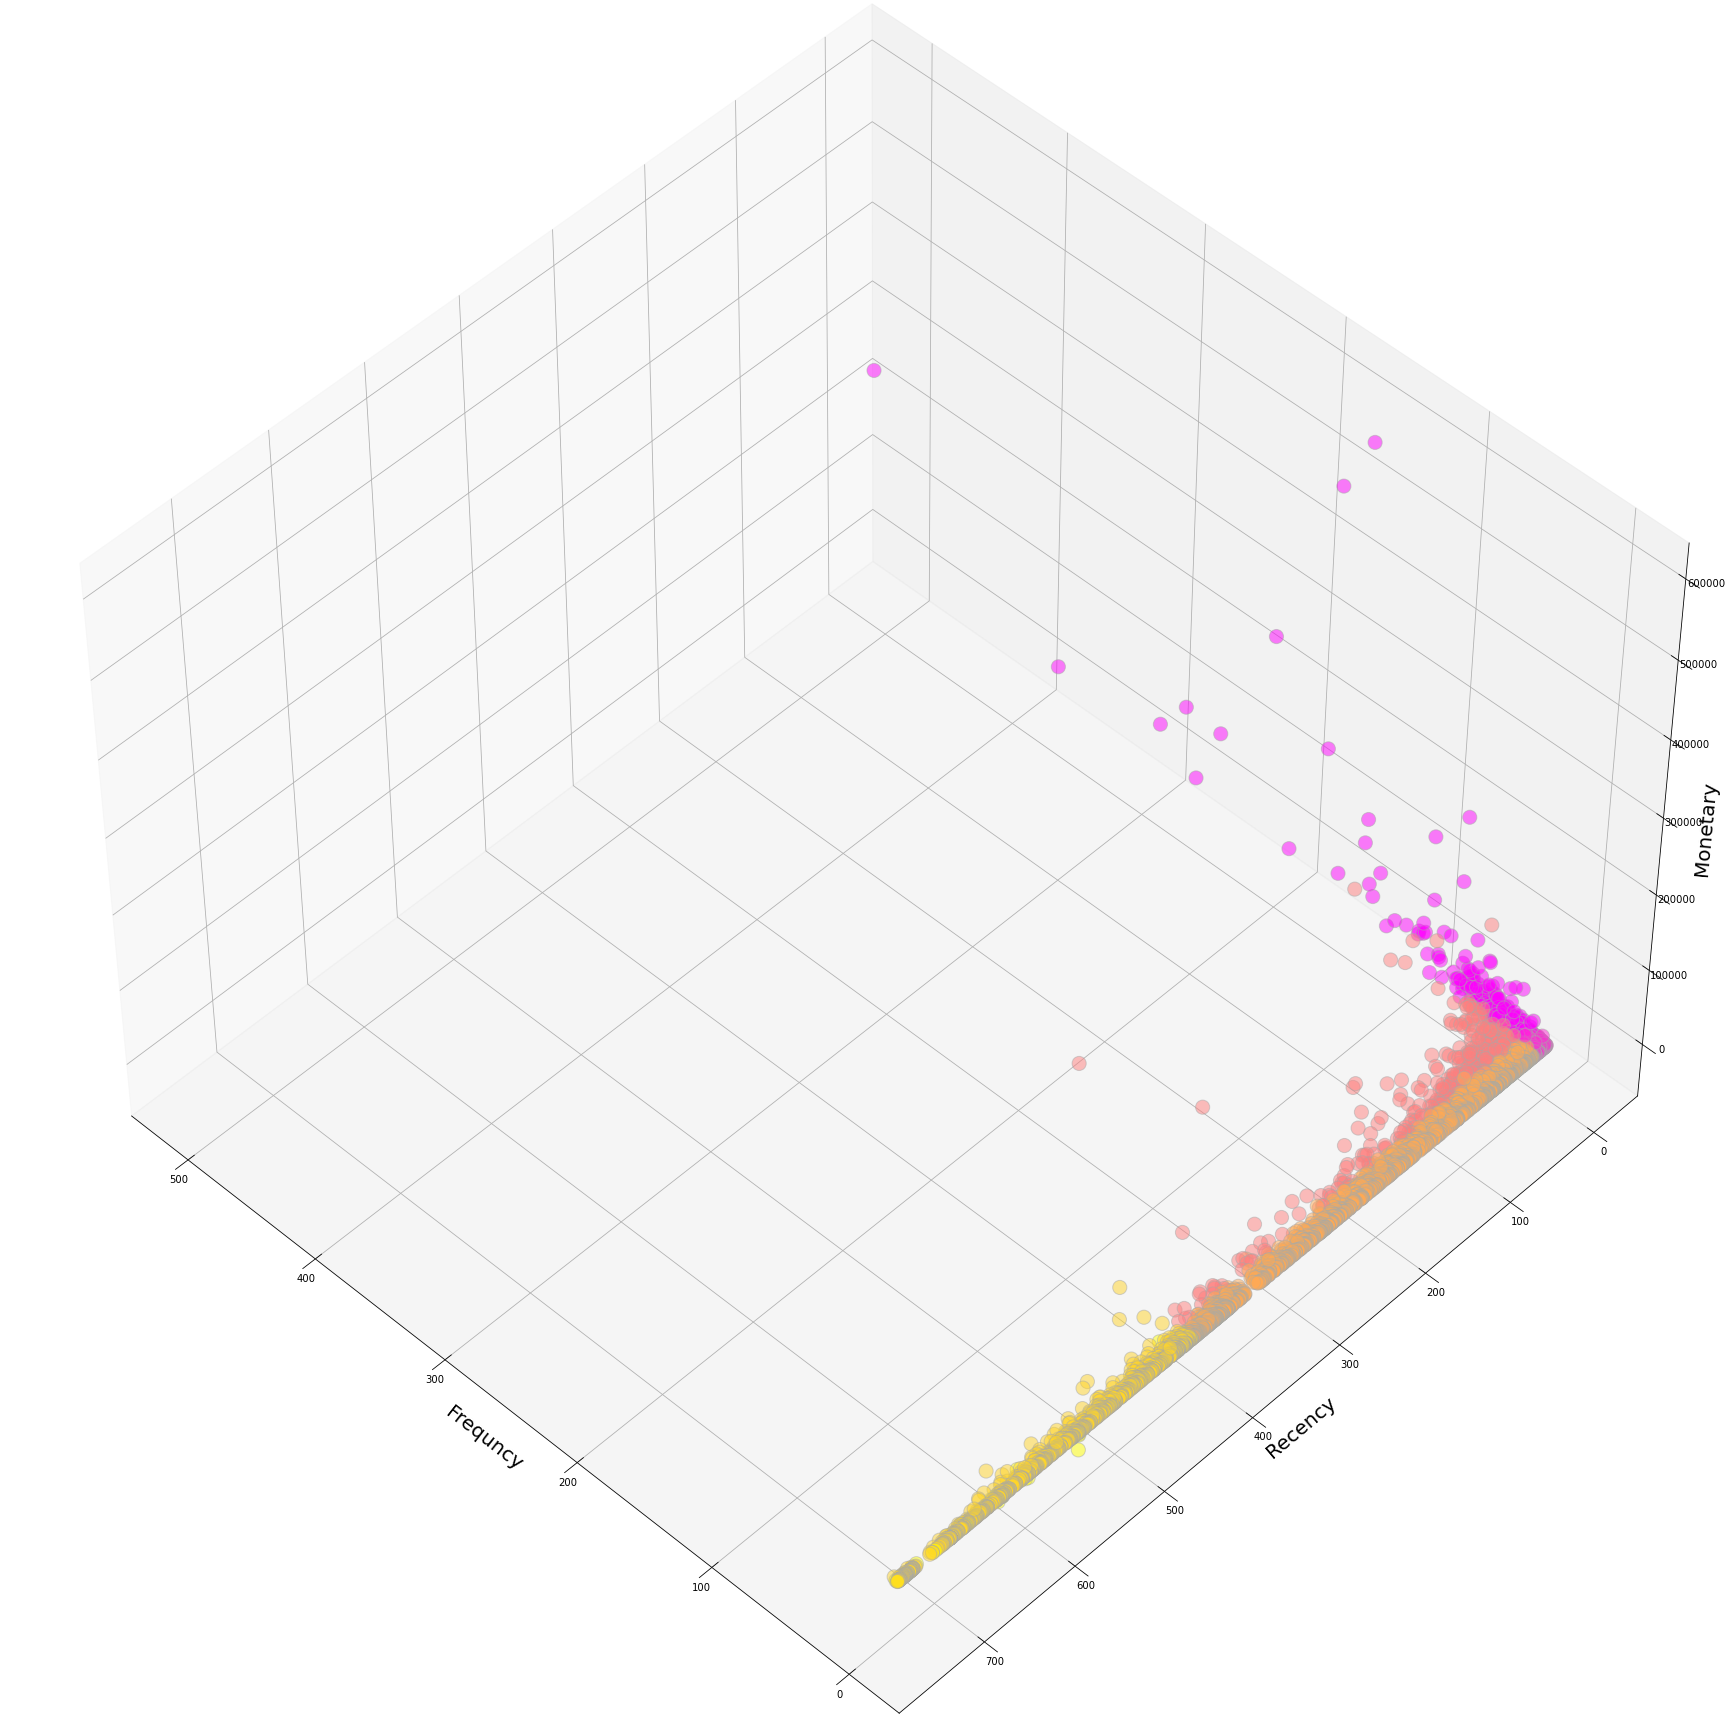

In [138]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"]=(25,25)
fig=plt.figure(1)
plt.clf()
ax=Axes3D(fig,rect=[0,0,.95,1], elev=48, azim=134)
plt.cla()
ax.scatter(rfm2_together['Purchase_Frequency'],rfm2_together['recency'],rfm2_together['Spending'],
           c=rfm2_together['cluster'],
          s=200,
          cmap='spring',
          alpha=0.5,
          edgecolor='darkgrey')
ax.set_xlabel('Frequncy',fontsize=20)
ax.set_ylabel('Recency',fontsize=20)
ax.set_zlabel('Monetary',fontsize=20)
plt.show()

<AxesSubplot:>

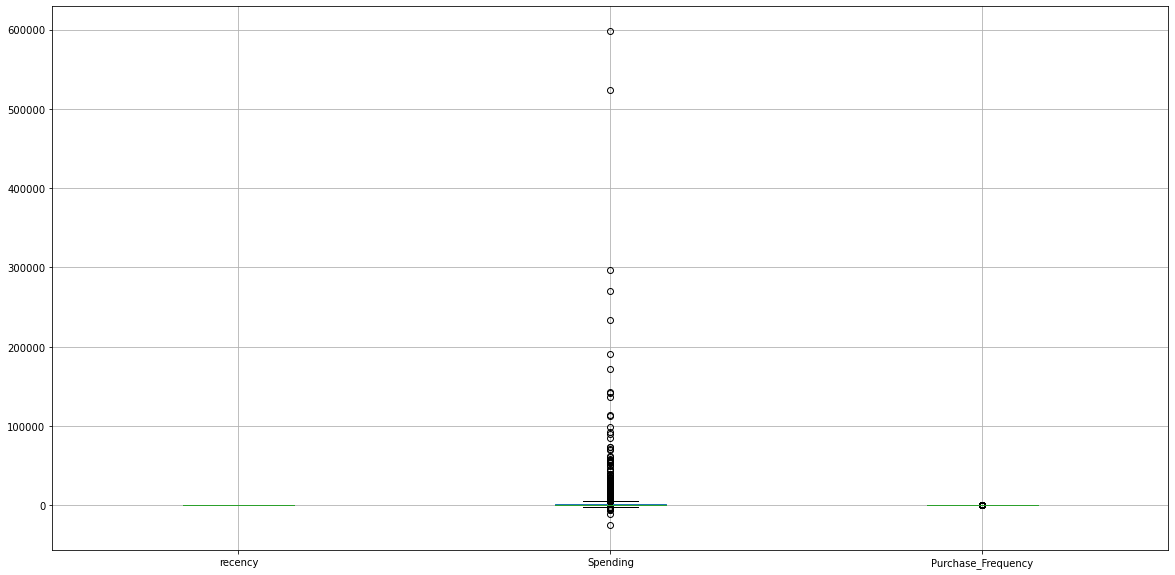

In [167]:
# Outliers exist in the data

rfm2_together.boxplot(column=['recency','Spending','Purchase_Frequency'], by=None, ax=None, fontsize=10, rot=0, grid=True, figsize=(20,10), layout=None, return_type=None, backend=None)

In [211]:
# remove outliers by normalizing
scaler=StandardScaler()
rfm2_normalized=rfm2_together[['Spending','Purchase_Frequency','recency']]
rfm2_normalized

,Spending,Purchase_Frequency,recency
13,8714.89,14,8.0
16,5284.58,14,3.0
49,5046.92,18,16.0
71,6708.21,27,3.0
77,2612.19,11,1.0
...,...,...,...
5315,-54.00,1,641.0
5409,-72.23,1,424.0
5597,-165.03,1,680.0
5677,-3248.86,1,540.0


In [212]:
rfm2_scaled=scaler.fit_transform(rfm2_normalized)
rfm2_scaled=pd.DataFrame(rfm2_scaled,index = rfm2_normalized.index,columns = rfm2_normalized.columns)
rfm2_scaled

,Spending,Purchase_Frequency,recency
13,0.423187,0.409741,-0.920074
16,0.177687,0.409741,-0.943677
49,0.160679,0.662340,-0.882310
71,0.279574,1.230689,-0.943677
77,-0.013570,0.220291,-0.953118
...,...,...,...
5315,-0.204384,-0.411208,2.068029
5409,-0.205688,-0.411208,1.043671
5597,-0.212330,-0.411208,2.252130
5677,-0.433033,-0.411208,1.591254


<AxesSubplot:>

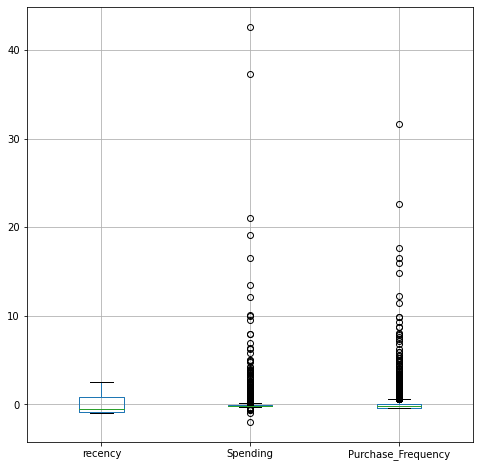

In [245]:
# after normalization
rfm2_scaled.boxplot(column=['recency','Spending','Purchase_Frequency'], by=None, ax=None, fontsize=10, rot=0, grid=True, figsize=(8,8), layout=None, return_type=None, backend=None)

In [214]:
#K Means Clustering

kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm2_scaled)

KMeans(max_iter=50, n_clusters=4)

In [219]:
sum_of_sq_dist={}
for num_clusters in range(1,15):
    kmeans=KMeans(n_clusters=num_clusters,init='k-means++',max_iter=1000)
    kmeans.fit(rfm2_scaled)
    sum_of_sq_dist[num_clusters]=kmeans.inertia_

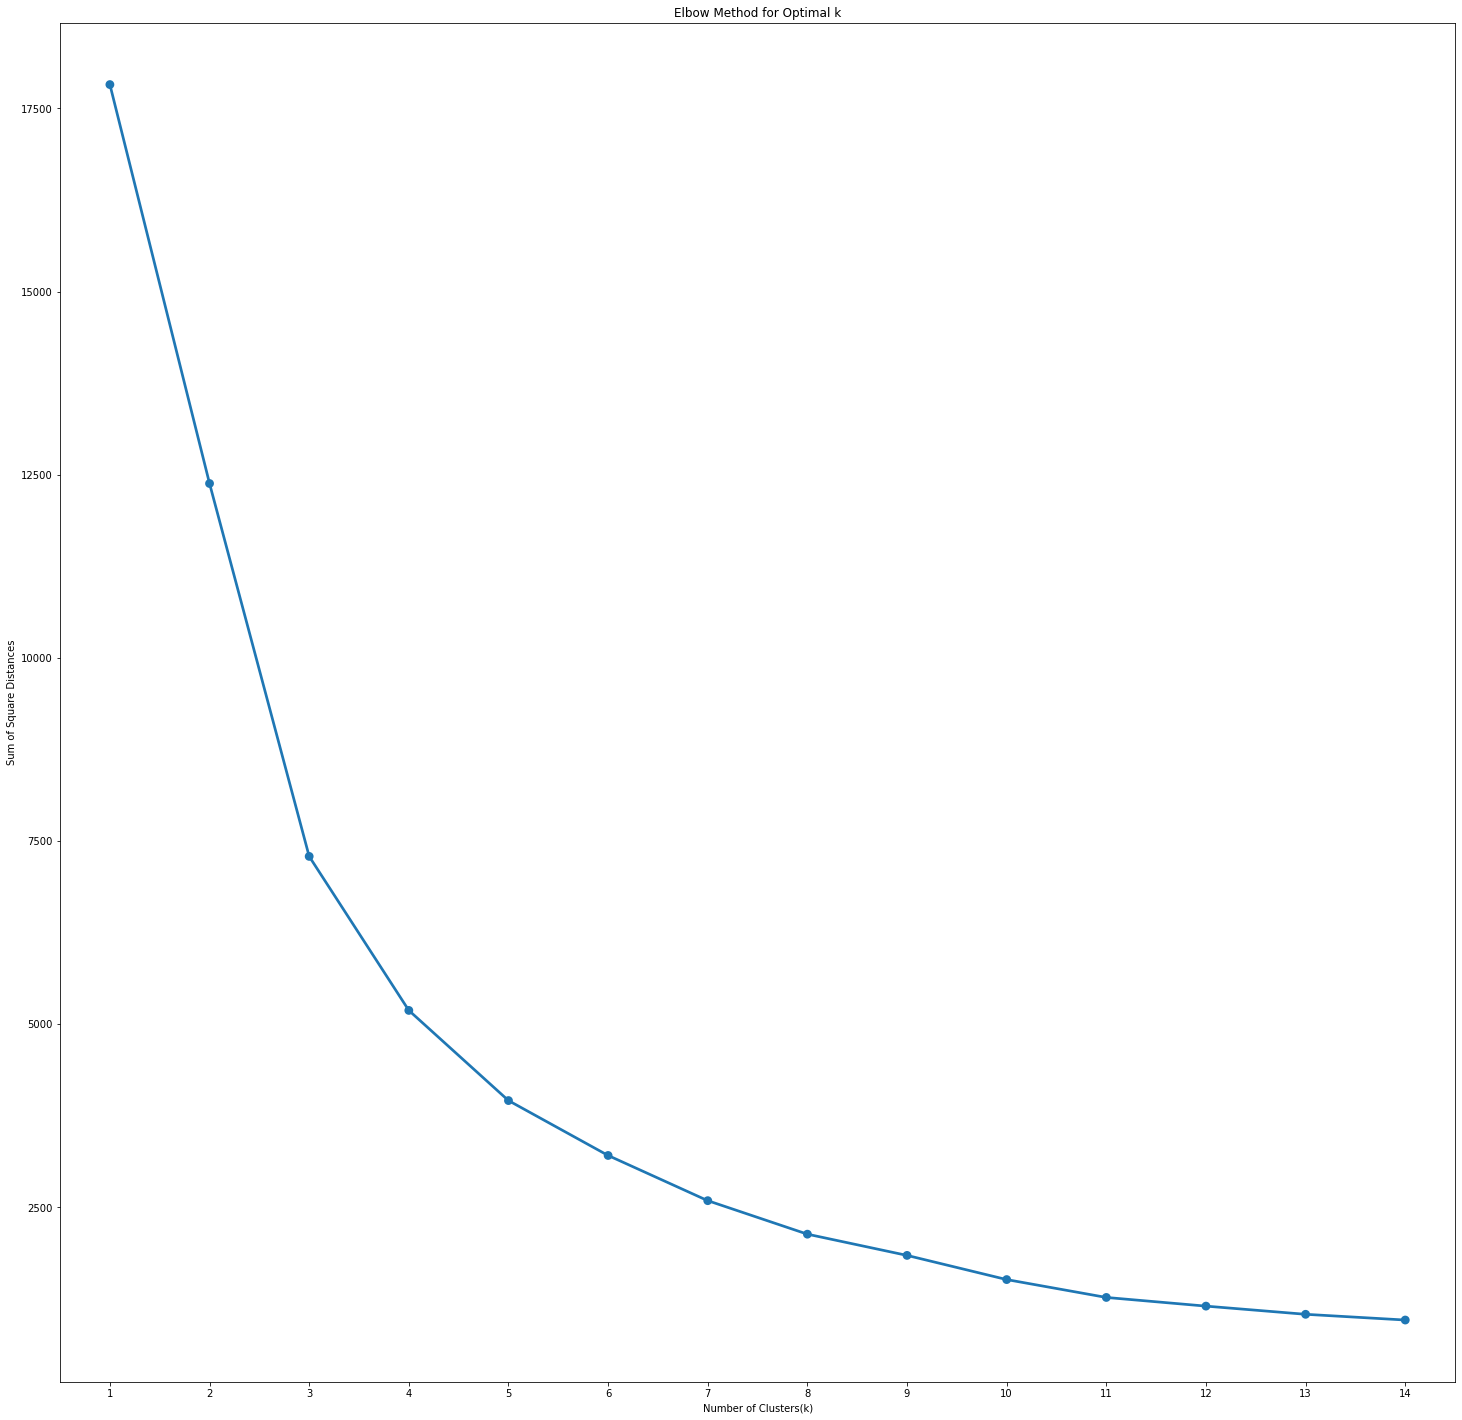

In [220]:
# Elbow Curve
sns.pointplot(x=list(sum_of_sq_dist.keys()),y=list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [234]:
#Elbow bends at 3. So 3 clusters
# K-means clustering
KMean_clust=KMeans(n_clusters=3,init='k-means++',max_iter=1000)
KMean_clust.fit(rfm2)
rfm2['KMeans_Cluster']=KMean_clust.labels_
rfm2.head()

,Customer ID,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm,rfm_scores,KMeans_Cluster
0,12346.0,326.0,-64.68,17,2,3,1,231,6,0
1,12347.0,2.0,5633.32,8,3,2,3,323,8,0
2,12348.0,75.0,2019.40,5,2,2,3,223,7,0
3,12349.0,19.0,4404.54,5,2,2,3,223,7,0
4,12350.0,310.0,334.40,1,2,1,3,213,6,0


<Figure size 504x504 with 0 Axes>

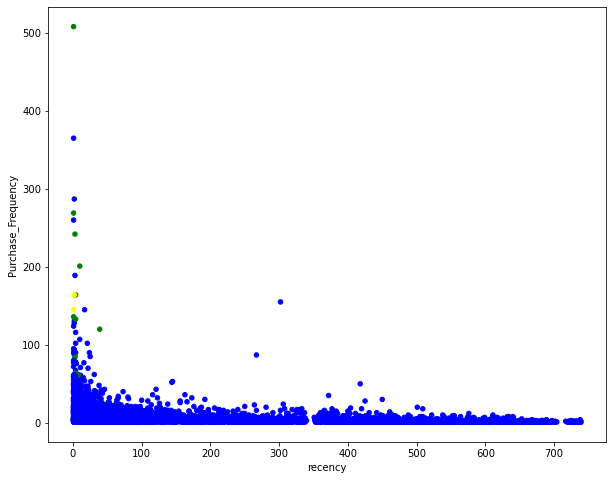

In [246]:
# fitting with 3 clusters
#scatter plot Frequency vs. Recency

plt.figure(figsize=(7,7))

Colors=["blue","green","yellow"]
rfm2['Colors']=rfm2['KMeans_Cluster'].map(lambda p:Colors[p])
ax=rfm2.plot(
    kind="scatter",
    x="recency",y="Purchase_Frequency",
    figsize=(10,8),
    c=rfm2['Colors']
)

<Figure size 504x504 with 0 Axes>

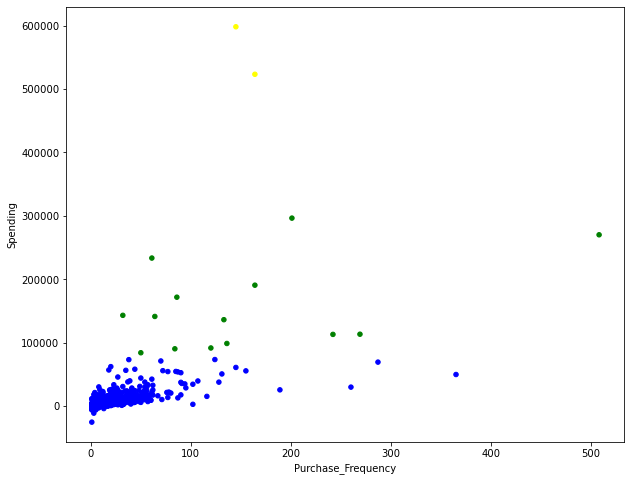

In [247]:
#scatter plot Frequency vs. Monetary

plt.figure(figsize=(7,7))

Colors=["blue","green","yellow"]
rfm2['Colors']=rfm2['KMeans_Cluster'].map(lambda p:Colors[p])
ax=rfm2.plot(
    kind="scatter",
    x="Purchase_Frequency",y="Spending",
    figsize=(10,8),
    c=rfm2['Colors']
)

<Figure size 504x504 with 0 Axes>

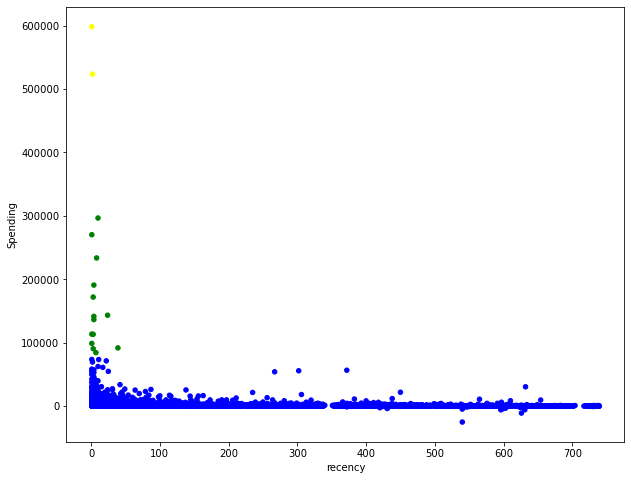

In [248]:
#scatter plot Recency vs. Monetary

plt.figure(figsize=(7,7))

Colors=["blue","green","yellow"]
rfm2['Colors']=rfm2['KMeans_Cluster'].map(lambda p:Colors[p])
ax=rfm2.plot(
    kind="scatter",
    x="recency",y="Spending",
    figsize=(10,8),
    c=rfm2['Colors']
)

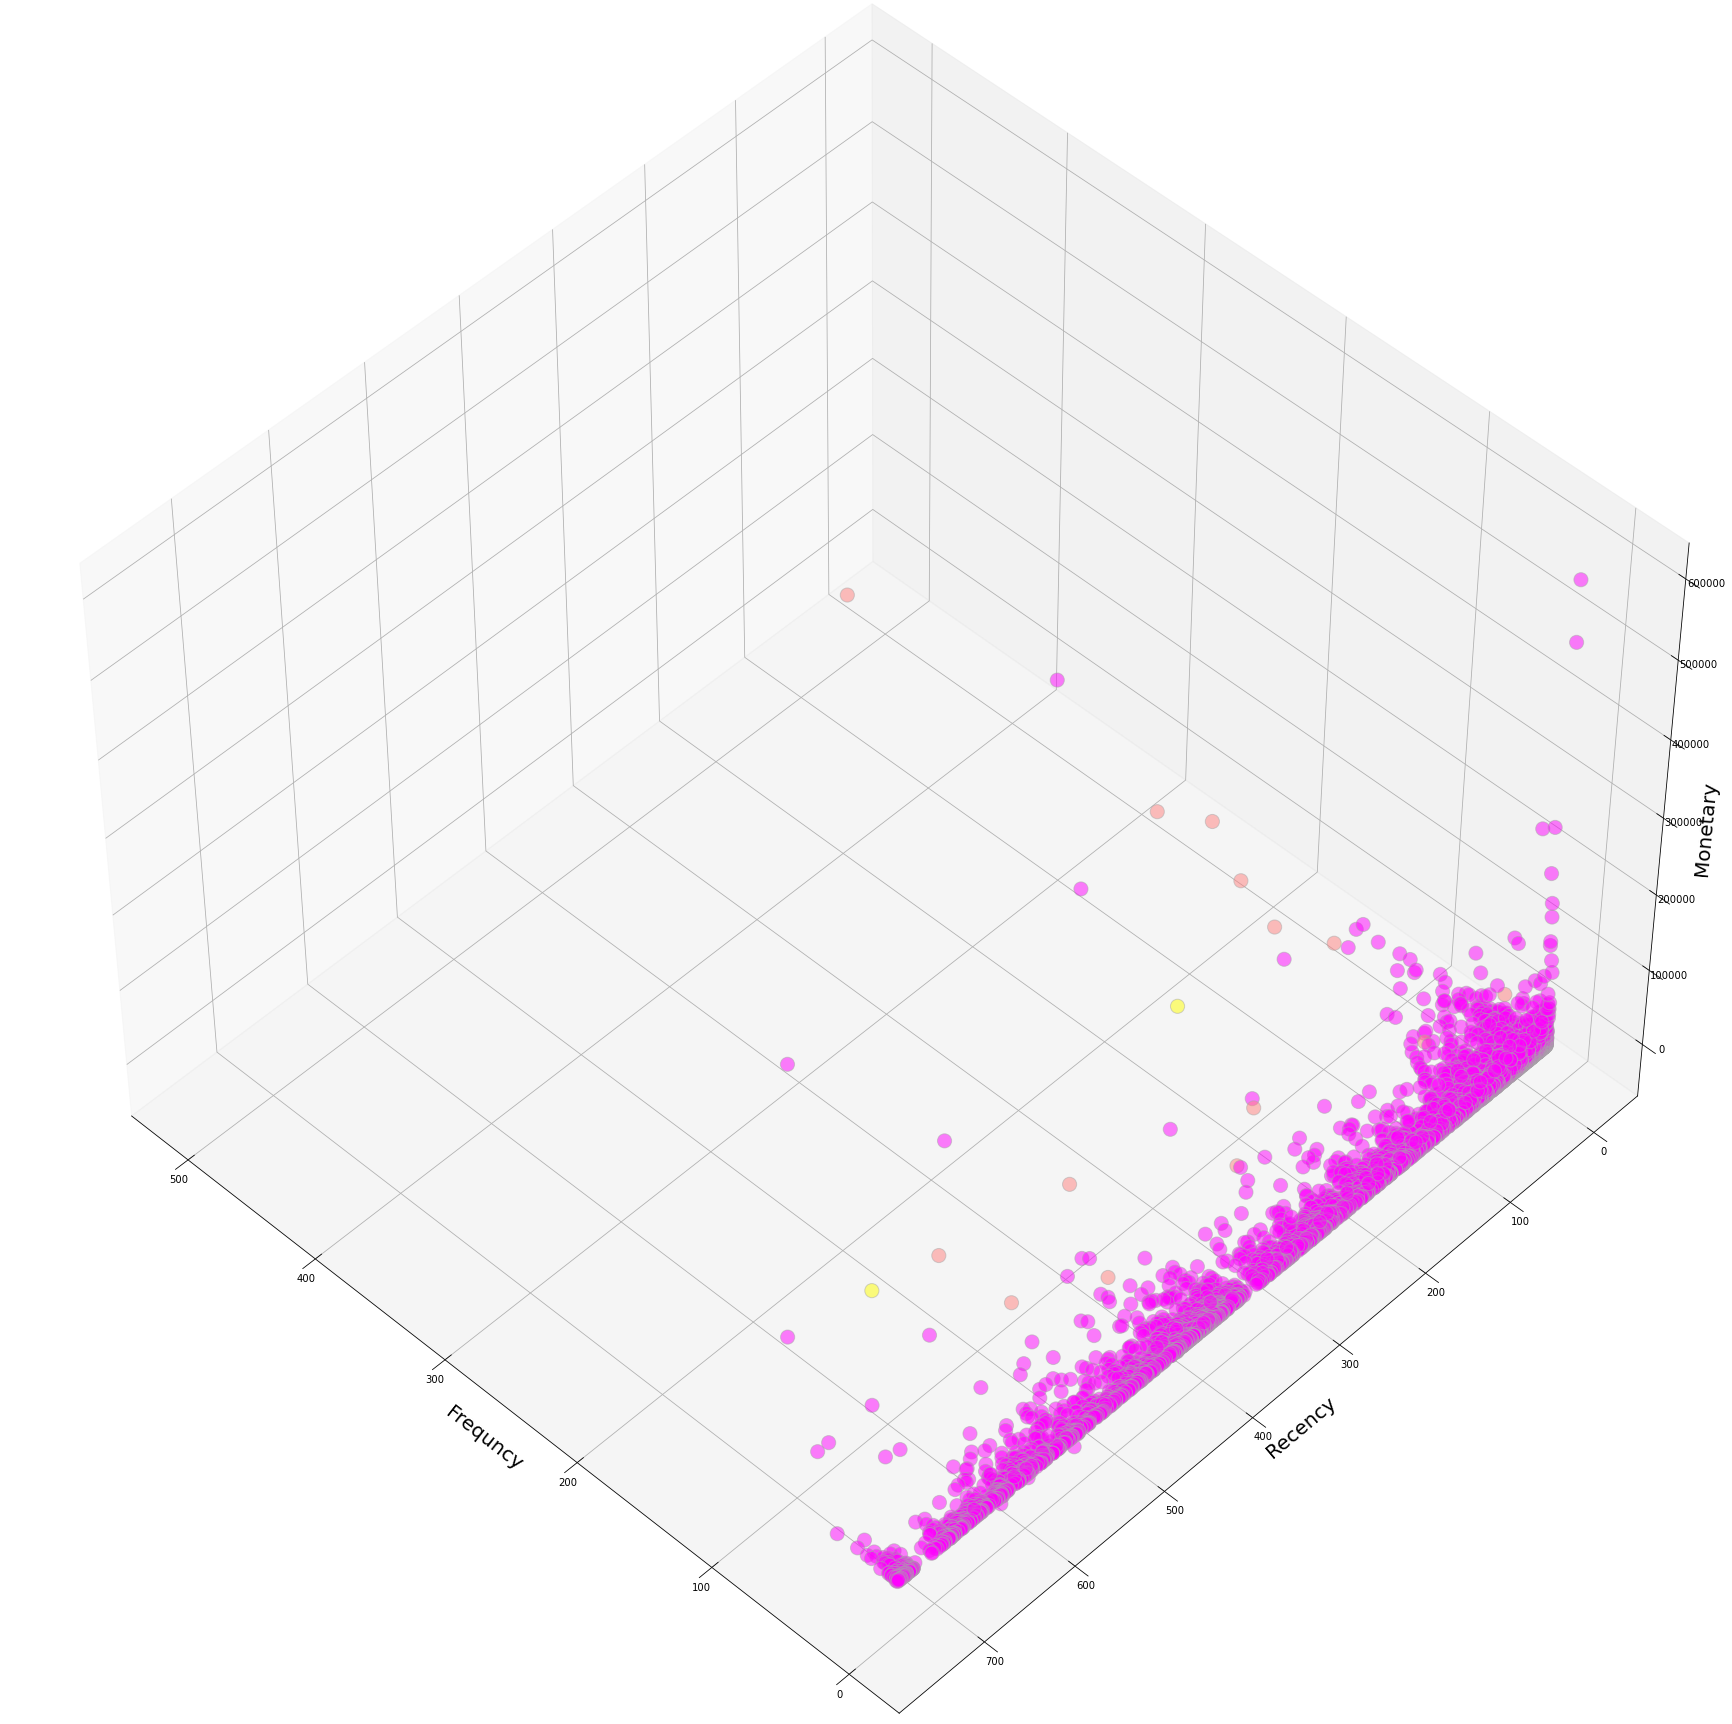

In [241]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"]=(25,25)
fig=plt.figure(1)
plt.clf()
ax=Axes3D(fig,rect=[0,0,.95,1], elev=48, azim=134)
plt.cla()
ax.scatter(rfm2['Purchase_Frequency'],rfm2_together['recency'],rfm2_together['Spending'],
           c=rfm2['KMeans_Cluster'],
          s=200,
          cmap='spring',
          alpha=0.5,
          edgecolor='darkgrey')
ax.set_xlabel('Frequncy',fontsize=20)
ax.set_ylabel('Recency',fontsize=20)
ax.set_zlabel('Monetary',fontsize=20)
plt.show()

In [ ]:
Issues: low recency, low monetary clusterd with high recency